In [576]:
%pip install numpy pandas tensorflow matplotlib scikit-learn keras statsmodels keras_tuner optuna

Note: you may need to restart the kernel to use updated packages.


In [577]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import r2_score

In [578]:
# Cargar los datos
data = pd.read_csv('datos_limpios0.csv')
data.shape

(1161, 15)

**Factores:**
- **Date**: Date in MM-DD-YYYY
- **Quarter**: A portion of the month. A month was divided into four quarters
- **Department**: Associated department with the instance
- **Day**: Day of the Week
- **Team**: Associated team number with the instance
- **Targeted productivity**: Targeted productivity set by the Authority for each team for each day.
- **SMV**: Standard Minute Value, it is the allocated time for a task
- **WIP**: Work in progress. Includes the number of unfinished items for products
- **Over time**: Represents the amount of overtime by each team in minutes
- **Incentive**: Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
- **Idle time**: The amount of time when the production was interrupted due to several reasons
- **Idle men**: The number of workers who were idle due to production interruption
- **No of style change**: Number of changes in the style of a particular product
- **No of workers**: Number of workers in each team

**Variable de respuesta:**
- **Actual productivity**: The actual % of productivity that was delivered by the workers. It ranges from 0-1.



In [579]:
# Convertir la columna 'Date' a tipo datetime
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Extraer día, mes y año de la columna 'Date'
data['Day'] = data['date'].dt.day
data['Month'] = data['date'].dt.month
data['Year'] = data['date'].dt.year

# Eliminar la columna 'Date'
data.drop(columns=['date'], inplace=True)

# Mostrar las primeras filas del DataFrame
data.head()

,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,Day,Month,Year
0,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1,1,2015
1,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500,1,1,2015
2,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1,2015
3,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,1,1,2015
4,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382,1,1,2015


In [580]:
# Realizo una copia del DataFrame original
data_encoded = data.copy()

# Codificar las columnas categóricas en la copia
data_encoded['quarter'] = data_encoded['quarter'].astype('category').cat.codes
data_encoded['department'] = data_encoded['department'].astype('category').cat.codes
data_encoded['day'] = data_encoded['day'].astype('category').cat.codes
data_encoded['team'] = data_encoded['team'].astype('category').cat.codes

In [581]:
data_encoded.columns.tolist()

['quarter',
 'department',
 'day',
 'team',
 'targeted_productivity',
 'smv',
 'wip',
 'over_time',
 'incentive',
 'idle_time',
 'idle_men',
 'no_of_style_change',
 'no_of_workers',
 'actual_productivity',
 'Day',
 'Month',
 'Year']

In [582]:
features = ['quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']

X = data_encoded[features]

X = pd.get_dummies(X, columns=['day', 'team', 'quarter', 'department'], dtype=int, drop_first=True)
X.head()


,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,day_1,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
0,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0,...,1,0,0,0,0,0,0,0,0,1
1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0,...,0,0,0,1,0,0,0,0,0,1
3,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0,...,0,0,0,0,1,0,0,0,0,1
4,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0,...,0,0,0,0,0,0,0,0,0,1


In [583]:
features_Y = ['quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']

X_more = data_encoded[features_Y]
X_more = pd.get_dummies(X_more, columns=['day', 'team', 'quarter', 'department'], dtype=int, drop_first=True)


In [584]:
X_more.shape

(1161, 31)

In [585]:
Y = data_encoded["actual_productivity"]

Y.head()

0    0.940725
1    0.886500
2    0.800570
3    0.800570
4    0.800382
Name: actual_productivity, dtype: float64

In [586]:
train = X_more.sample(frac=0.8, random_state=100)
train.head()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
892,0.8,15.26,1053.0,4080,50,0.0,0,0,34.0,0.800402,...,0,0,0,0,1,0,0,1,0,1
492,0.8,4.30,0.0,1200,0,0.0,0,0,10.0,0.989000,...,0,0,0,0,0,0,0,0,1,0
137,0.8,19.87,857.0,9900,50,0.0,0,0,55.0,0.800274,...,0,0,0,0,0,1,0,0,0,1
638,0.8,3.94,0.0,1200,0,0.0,0,0,10.0,0.893067,...,0,0,0,0,0,1,0,0,0,0
918,0.7,30.33,398.0,6960,0,0.0,0,1,58.0,0.662379,...,0,0,0,0,0,0,0,1,0,1


In [587]:
test = X_more.drop(train.index)
test.head()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
2,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570,...,0,0,0,1,0,0,0,0,0,1
11,0.75,19.31,578.0,6480,45,0.0,0,0,54.0,0.712205,...,0,0,1,0,0,0,0,0,0,1
13,0.65,3.94,0.0,960,0,0.0,0,0,8.0,0.705917,...,0,0,1,0,0,0,0,0,0,0
17,0.65,23.69,861.0,7200,0,0.0,0,0,60.0,0.521180,...,0,0,0,0,0,0,0,0,0,1
34,0.75,19.87,944.0,6600,45,0.0,0,0,55.0,0.750243,...,0,0,0,0,0,0,0,0,0,1


In [588]:
print(train.shape)
print(test.shape)

(929, 31)
(232, 31)


Realicemos una exploración descriptiva de los datos, calculando inicialmente estadísticas de cada variable continua

In [589]:
train.describe()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
count,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,...,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000,929.000000
mean,0.727417,15.149343,672.769645,4623.907427,39.216362,0.919806,0.368138,0.152853,34.488698,0.727403,...,0.092573,0.086114,0.086114,0.075350,0.079656,0.296017,0.163617,0.205597,0.036598,0.575888
std,0.099696,11.110655,1425.421899,3351.519288,178.173115,14.419002,3.277420,0.428378,22.288859,0.169832,...,0.289989,0.280684,0.280684,0.264097,0.270905,0.456745,0.370127,0.404355,0.187875,0.494474
min,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.700000,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650148,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.750000,15.260000,610.000000,4080.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.753683,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.800000,25.900000,1079.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.849984,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
max,0.800000,54.560000,21540.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.020000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Seleccionamos ahora las características y las etiquetas (MPG)

In [590]:
X_train = train.copy()
X_test = test.copy()

In [591]:
y_train = X_train.pop('actual_productivity')
y_test = X_test.pop('actual_productivity')

In [592]:
X_train.head()

,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,day_1,...,team_7,team_8,team_9,team_10,team_11,quarter_1,quarter_2,quarter_3,quarter_4,department_1
892,0.8,15.26,1053.0,4080,50,0.0,0,0,34.0,0,...,0,0,0,0,1,0,0,1,0,1
492,0.8,4.30,0.0,1200,0,0.0,0,0,10.0,0,...,0,0,0,0,0,0,0,0,1,0
137,0.8,19.87,857.0,9900,50,0.0,0,0,55.0,0,...,0,0,0,0,0,1,0,0,0,1
638,0.8,3.94,0.0,1200,0,0.0,0,0,10.0,0,...,0,0,0,0,0,1,0,0,0,0
918,0.7,30.33,398.0,6960,0,0.0,0,1,58.0,0,...,0,0,0,0,0,0,0,1,0,1


In [593]:
y_train.head()

892    0.800402
492    0.989000
137    0.800274
638    0.893067
918    0.662379
Name: actual_productivity, dtype: float64

In [594]:
#from sklearn import metrics
#import statsmodels.api as sm
#from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=1,test_size=0.2)


## Normalizacion

In [595]:
tf.keras.layers.Normalization
norm = tf.keras.layers.Normalization()

In [596]:
norm.adapt(np.array(X_train))

In [597]:
norm.mean.numpy()

array([[7.27416575e-01, 1.51493435e+01, 6.72769653e+02, 4.62390723e+03,
        3.92163620e+01, 9.19806242e-01, 3.68137777e-01, 1.52852535e-01,
        3.44886971e+01, 1.57158241e-01, 1.78686753e-01, 1.61463946e-01,
        1.63616791e-01, 1.70075357e-01, 7.96555430e-02, 8.50376785e-02,
        9.14962292e-02, 7.42734149e-02, 7.85791203e-02, 8.61141011e-02,
        9.25726593e-02, 8.61141011e-02, 8.61141011e-02, 7.53498375e-02,
        7.96555430e-02, 2.96017230e-01, 1.63616791e-01, 2.05597416e-01,
        3.65984924e-02, 5.75888038e-01]], dtype=float32)

In [598]:
norm.variance.numpy()

array([[9.9285254e-03, 1.2331378e+02, 2.0296405e+06, 1.1220590e+07,
        3.1711486e+04, 2.0768382e+02, 1.0729921e+01, 1.8330994e-01,
        4.9625848e+02, 1.3245952e-01, 1.4675780e-01, 1.3539334e-01,
        1.3684633e-01, 1.4114973e-01, 7.3310539e-02, 7.7806272e-02,
        8.3124675e-02, 6.8756871e-02, 7.2404437e-02, 7.8698464e-02,
        8.4002964e-02, 7.8698464e-02, 7.8698464e-02, 6.9672242e-02,
        7.3310539e-02, 2.0839103e-01, 1.3684633e-01, 1.6332711e-01,
        3.5259042e-02, 2.4424100e-01]], dtype=float32)

## Modelo lineal

In [599]:
import numpy as np
import pandas as pd
import tensorflow as tf
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from sklearn.metrics import r2_score

# Definimos la clase del modelo lineal
class LinearHyperModel(HyperModel):
    def build(self, hp):
        model = tf.keras.Sequential([
            norm,  # Asegúrate de que 'norm' esté definido antes
            tf.keras.layers.Dense(units=1)  # Capa de salida
        ])
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', 1e-4, 1e-1, sampling='LOG')),
            loss=hp.Choice('loss', ['mean_absolute_error', 'mean_squared_error'])  # Cambiamos para iterar por diferentes tipos de loss
        )
        return model

# Instanciamos el objeto del buscador
tuner = RandomSearch(
    LinearHyperModel(),
    objective='val_loss',  # Usamos val_loss como objetivo durante la búsqueda
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='linear_optimization'
)

# Ajustamos el modelo
tuner.search(X_train, y_train, epochs=100, validation_split=0.2)

# Resultados de la mejor configuración
best_model_linear = tuner.get_best_models(num_models=1)[0]
best_hyperparameters_linear = tuner.get_best_hyperparameters(num_trials=1)[0]

# Evaluamos el mejor modelo en el conjunto de prueba
test_loss = best_model_linear.evaluate(X_train, y_train, verbose=0)

# Predicciones y cálculo del R² en el conjunto de prueba
linear_predictions = best_model_linear.predict(X_train)
r2_linear = r2_score(y_train, linear_predictions)

# Guardamos las métricas en variables
best_learning_rate = best_hyperparameters_linear.get('learning_rate')
best_loss_function = best_hyperparameters_linear.get('loss')

# Imprimimos los resultados de forma bonita
print("Mejores Hiperparámetros para el Modelo Lineal:")
print(f"  - Tasa de aprendizaje: {best_learning_rate:.5f}")
print(f"  - Función de pérdida: {best_loss_function}")
print(f"Métricas del Mejor Modelo Lineal: {test_loss:.4f}")
print(f"Métricas del Mejor Modelo Lineal (R²): {r2_linear:.4f}")

# Guardar los resultados en un diccionario
test_res_linear = {
    'loss': test_loss,
    'r2': r2_linear,
    'learning_rate': best_learning_rate,
    'loss_function': best_loss_function
}


Reloading Tuner from my_dir/linear_optimization/tuner0.json


/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
Mejores Hiperparámetros para el Modelo Lineal:
  - Tasa de aprendizaje: 0.00994
  - Función de pérdida: mean_squared_error
Métricas del Mejor Modelo Lineal: 0.0205
Métricas del Mejor Modelo Lineal (R²): 0.2880


In [600]:
linear_model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense(units=1)
])

In [601]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=test_res_linear['learning_rate']),
    loss=test_res_linear['loss_function'])

In [602]:
%%time
history = linear_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5212 - val_loss: 1.0105
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 0.6393 - val_loss: 0.4636
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 0.1395 - val_loss: 0.2996
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 0.1018 - val_loss: 0.1887
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 0.0633 - val_loss: 0.1404
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - loss: 0.0376 - val_loss: 0.1132
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - loss: 0.0321 - val_loss: 0.0981
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.0367 - val_loss: 0.0709
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0391 - val_loss: 0.0617
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.0536
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 0.0280 - val_loss: 0.0411
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 88

In [603]:
linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 30)             │            61 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156 (632.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 61 (248.00 B)

 Optimizer params: 64 (260.00 B)

In [604]:
import matplotlib.pyplot as plt

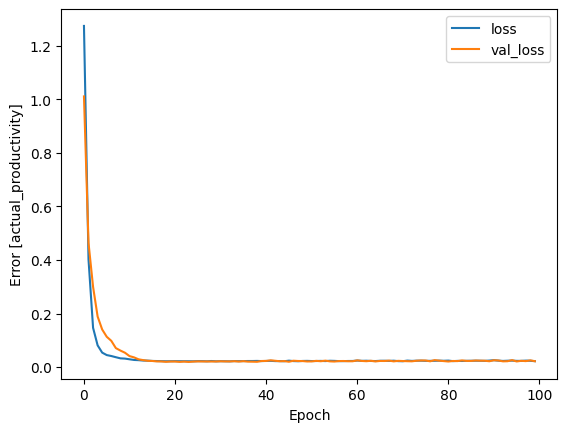

In [605]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

In [606]:
test_res = {}
test_res['linear_model'] = linear_model.evaluate(
    X_test,
    y_test, verbose=0)

In [607]:
test_res

{'linear_model': 0.02271071821451187}

## DNN

In [608]:
import optuna

# Definimos la función objetivo para la optimización
def objective(trial):
    # Definir hiperparámetros a optimizar
    num_layers = trial.suggest_int('num_layers', 1, 5)  # Número de capas ocultas
    units = [trial.suggest_int(f'units_{i}', 32, 128) for i in range(num_layers)]  # Unidades en cada capa
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])  # Función de activación
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje

    # Construir el modelo
    dnn_model = tf.keras.Sequential()
    dnn_model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

    # Añadir las capas ocultas
    for units in units:
        dnn_model.add(tf.keras.layers.Dense(units, activation=activation))

    # Capa de salida
    dnn_model.add(tf.keras.layers.Dense(1))

    # Compilar el modelo
    dnn_model.compile(loss='mean_absolute_error',
                      optimizer=tf.keras.optimizers.Adam(learning_rate))

    # Entrenar el modelo
    history = dnn_model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=100,
        verbose=0
    )

    # Hacer predicciones en el conjunto de validación
    val_predictions = dnn_model.predict(X_train)

    # Calcular el R^2
    r2 = r2_score(y_train, val_predictions)

    return r2

# Crear un estudio y ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Imprimir los mejores hiperparámetros
print("Mejores hiperparámetros:", study.best_params)
print("Mejor R^2:", study.best_value)

# Puedes usar los mejores hiperparámetros para entrenar tu modelo final


/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-10-17 07:33:20,086] A new study created in memory with name: no-name-4abd1fe9-3449-4717-a949-77cb0d414f33
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:33:23,785] Trial 0 finished with value: -0.062081527886546084 and parameters: {'num_layers': 1, 'units_0': 34, 'activation': 'relu', 'learning_rate': 0.03359240747073245}. Best is trial 0 with value: -0.062081527886546084.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step


[I 2024-10-17 07:33:27,655] Trial 1 finished with value: -0.07544515473421476 and parameters: {'num_layers': 3, 'units_0': 90, 'units_1': 60, 'units_2': 102, 'activation': 'sigmoid', 'learning_rate': 0.001120737835063432}. Best is trial 0 with value: -0.062081527886546084.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:33:32,024] Trial 2 finished with value: -0.0009629397085089142 and parameters: {'num_layers': 4, 'units_0': 78, 'units_1': 105, 'units_2': 107, 'units_3': 71, 'activation': 'relu', 'learning_rate': 0.09709754542650936}. Best is trial 2 with value: -0.0009629397085089142.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:33:36,636] Trial 3 finished with value: -0.7643305457267828 and parameters: {'num_layers': 5, 'units_0': 125, 'units_1': 99, 'units_2': 100, 'units_3': 74, 'units_4': 108, 'activation': 'tanh', 'learning_rate': 0.003323177945262716}. Best is trial 2 with value: -0.0009629397085089142.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step


[I 2024-10-17 07:33:40,142] Trial 4 finished with value: -2393.9296226242873 and parameters: {'num_layers': 2, 'units_0': 68, 'units_1': 39, 'activation': 'relu', 'learning_rate': 0.00015484126185045735}. Best is trial 2 with value: -0.0009629397085089142.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step


[I 2024-10-17 07:33:44,090] Trial 5 finished with value: -0.028685913360514848 and parameters: {'num_layers': 3, 'units_0': 91, 'units_1': 59, 'units_2': 64, 'activation': 'tanh', 'learning_rate': 1.2555087447911196e-05}. Best is trial 2 with value: -0.0009629397085089142.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


[I 2024-10-17 07:33:47,334] Trial 6 finished with value: 0.0024430299078914697 and parameters: {'num_layers': 1, 'units_0': 77, 'activation': 'sigmoid', 'learning_rate': 0.009270941774523372}. Best is trial 6 with value: 0.0024430299078914697.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step


[I 2024-10-17 07:33:50,641] Trial 7 finished with value: -0.5756527639993279 and parameters: {'num_layers': 1, 'units_0': 111, 'activation': 'tanh', 'learning_rate': 0.0031234895437755113}. Best is trial 6 with value: 0.0024430299078914697.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


[I 2024-10-17 07:33:54,358] Trial 8 finished with value: -0.007447267682508141 and parameters: {'num_layers': 2, 'units_0': 68, 'units_1': 77, 'activation': 'sigmoid', 'learning_rate': 0.014611724344693041}. Best is trial 6 with value: 0.0024430299078914697.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:33:58,426] Trial 9 finished with value: -0.07425940484190896 and parameters: {'num_layers': 4, 'units_0': 112, 'units_1': 68, 'units_2': 69, 'units_3': 115, 'activation': 'sigmoid', 'learning_rate': 0.011148595162214676}. Best is trial 6 with value: 0.0024430299078914697.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step


[I 2024-10-17 07:34:01,988] Trial 10 finished with value: 0.2651655542736553 and parameters: {'num_layers': 2, 'units_0': 41, 'units_1': 128, 'activation': 'sigmoid', 'learning_rate': 0.00024599972220568176}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step


[I 2024-10-17 07:34:05,497] Trial 11 finished with value: -0.05708057620355911 and parameters: {'num_layers': 2, 'units_0': 35, 'units_1': 128, 'activation': 'sigmoid', 'learning_rate': 0.0001476982658947612}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:34:09,416] Trial 12 finished with value: -0.09609453700773285 and parameters: {'num_layers': 1, 'units_0': 54, 'activation': 'sigmoid', 'learning_rate': 0.00017322208045778093}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:34:13,125] Trial 13 finished with value: -0.08607574980321031 and parameters: {'num_layers': 2, 'units_0': 51, 'units_1': 128, 'activation': 'sigmoid', 'learning_rate': 2.5227532394572883e-05}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step


[I 2024-10-17 07:34:16,805] Trial 14 finished with value: -0.040111034254330935 and parameters: {'num_layers': 1, 'units_0': 52, 'activation': 'sigmoid', 'learning_rate': 0.0005519072978728016}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step


[I 2024-10-17 07:34:20,677] Trial 15 finished with value: -0.11772334912408322 and parameters: {'num_layers': 2, 'units_0': 91, 'units_1': 100, 'activation': 'sigmoid', 'learning_rate': 0.0006275078104084185}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step


[I 2024-10-17 07:34:23,927] Trial 16 finished with value: -0.29328860582290583 and parameters: {'num_layers': 1, 'units_0': 70, 'activation': 'sigmoid', 'learning_rate': 5.301590321746585e-05}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step


[I 2024-10-17 07:34:27,645] Trial 17 finished with value: -0.06216022829544232 and parameters: {'num_layers': 3, 'units_0': 42, 'units_1': 114, 'units_2': 32, 'activation': 'sigmoid', 'learning_rate': 0.002650011245576601}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 07:34:32,043] Trial 18 finished with value: -0.05356394999478775 and parameters: {'num_layers': 2, 'units_0': 102, 'units_1': 85, 'activation': 'relu', 'learning_rate': 0.008063956415122848}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:34:36,237] Trial 19 finished with value: -0.020566873843876454 and parameters: {'num_layers': 3, 'units_0': 56, 'units_1': 32, 'units_2': 36, 'activation': 'tanh', 'learning_rate': 0.0327063331371913}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:34:40,483] Trial 20 finished with value: -0.11310269815944052 and parameters: {'num_layers': 4, 'units_0': 82, 'units_1': 88, 'units_2': 125, 'units_3': 34, 'activation': 'sigmoid', 'learning_rate': 0.0012513069135902711}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:34:44,943] Trial 21 finished with value: -0.03041817187006557 and parameters: {'num_layers': 4, 'units_0': 76, 'units_1': 113, 'units_2': 127, 'units_3': 70, 'activation': 'relu', 'learning_rate': 0.09744681410613602}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 07:34:49,491] Trial 22 finished with value: -0.17282425235873156 and parameters: {'num_layers': 5, 'units_0': 64, 'units_1': 113, 'units_2': 99, 'units_3': 117, 'units_4': 36, 'activation': 'relu', 'learning_rate': 0.0927334695729715}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:34:53,590] Trial 23 finished with value: -0.10018609764988584 and parameters: {'num_layers': 4, 'units_0': 78, 'units_1': 101, 'units_2': 84, 'units_3': 45, 'activation': 'relu', 'learning_rate': 0.03651252261441447}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:34:57,976] Trial 24 finished with value: 0.007547614491023813 and parameters: {'num_layers': 5, 'units_0': 44, 'units_1': 119, 'units_2': 111, 'units_3': 94, 'units_4': 55, 'activation': 'relu', 'learning_rate': 0.007788109712139168}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step


[I 2024-10-17 07:35:02,083] Trial 25 finished with value: -5788.269780601926 and parameters: {'num_layers': 1, 'units_0': 42, 'activation': 'relu', 'learning_rate': 0.005625676739205643}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:35:06,647] Trial 26 finished with value: -0.057327727426686126 and parameters: {'num_layers': 5, 'units_0': 42, 'units_1': 120, 'units_2': 52, 'units_3': 94, 'units_4': 52, 'activation': 'sigmoid', 'learning_rate': 0.014970460880041987}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:35:10,283] Trial 27 finished with value: -0.04980804744232836 and parameters: {'num_layers': 2, 'units_0': 32, 'units_1': 122, 'activation': 'sigmoid', 'learning_rate': 0.0002920482336786154}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step


[I 2024-10-17 07:35:13,748] Trial 28 finished with value: -0.1898129008217233 and parameters: {'num_layers': 1, 'units_0': 60, 'activation': 'tanh', 'learning_rate': 0.001579854187184563}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step


[I 2024-10-17 07:35:17,013] Trial 29 finished with value: 0.1936054883638113 and parameters: {'num_layers': 1, 'units_0': 46, 'activation': 'relu', 'learning_rate': 0.024691592259900946}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 07:35:21,541] Trial 30 finished with value: -0.029300904934733474 and parameters: {'num_layers': 5, 'units_0': 47, 'units_1': 91, 'units_2': 85, 'units_3': 109, 'units_4': 77, 'activation': 'relu', 'learning_rate': 0.025374335821807432}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step


[I 2024-10-17 07:35:24,819] Trial 31 finished with value: -19927.613760352568 and parameters: {'num_layers': 1, 'units_0': 37, 'activation': 'relu', 'learning_rate': 0.006236489904887317}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step


[I 2024-10-17 07:35:28,233] Trial 32 finished with value: -0.06118226525178572 and parameters: {'num_layers': 1, 'units_0': 47, 'activation': 'relu', 'learning_rate': 0.0499655980273106}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:35:31,890] Trial 33 finished with value: -0.019569448994564143 and parameters: {'num_layers': 2, 'units_0': 60, 'units_1': 109, 'activation': 'relu', 'learning_rate': 0.02122054121433481}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 07:35:36,266] Trial 34 finished with value: -42.47757107516594 and parameters: {'num_layers': 3, 'units_0': 48, 'units_1': 120, 'units_2': 116, 'activation': 'relu', 'learning_rate': 6.974543419658376e-05}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


[I 2024-10-17 07:35:39,671] Trial 35 finished with value: -9755.785686439402 and parameters: {'num_layers': 1, 'units_0': 38, 'activation': 'relu', 'learning_rate': 0.004746436417699065}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:35:43,772] Trial 36 finished with value: -0.1513208474570269 and parameters: {'num_layers': 3, 'units_0': 32, 'units_1': 94, 'units_2': 88, 'activation': 'relu', 'learning_rate': 0.0020746812463935884}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


[I 2024-10-17 07:35:47,484] Trial 37 finished with value: -0.08474718265599646 and parameters: {'num_layers': 2, 'units_0': 84, 'units_1': 78, 'activation': 'tanh', 'learning_rate': 0.0005995447496157304}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step


[I 2024-10-17 07:35:50,897] Trial 38 finished with value: -3.356088160488011 and parameters: {'num_layers': 1, 'units_0': 96, 'activation': 'sigmoid', 'learning_rate': 0.05549189951054039}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step


[I 2024-10-17 07:35:55,805] Trial 39 finished with value: -0.08302976736506151 and parameters: {'num_layers': 2, 'units_0': 71, 'units_1': 47, 'activation': 'relu', 'learning_rate': 0.015205931000616481}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step


[I 2024-10-17 07:35:59,411] Trial 40 finished with value: -0.02264068070414149 and parameters: {'num_layers': 1, 'units_0': 124, 'activation': 'sigmoid', 'learning_rate': 0.009670256517624543}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:36:03,761] Trial 41 finished with value: -0.620145918970092 and parameters: {'num_layers': 4, 'units_0': 86, 'units_1': 107, 'units_2': 112, 'units_3': 89, 'activation': 'relu', 'learning_rate': 0.06475413254805804}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


[I 2024-10-17 07:36:08,122] Trial 42 finished with value: -0.018552540508201876 and parameters: {'num_layers': 5, 'units_0': 73, 'units_1': 105, 'units_2': 116, 'units_3': 57, 'units_4': 71, 'activation': 'relu', 'learning_rate': 0.024563060430189337}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:36:12,546] Trial 43 finished with value: -611.207047700263 and parameters: {'num_layers': 4, 'units_0': 65, 'units_1': 122, 'units_2': 105, 'units_3': 94, 'activation': 'relu', 'learning_rate': 0.0002920122068315721}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:36:17,085] Trial 44 finished with value: -0.46242642160560976 and parameters: {'num_layers': 5, 'units_0': 98, 'units_1': 117, 'units_2': 76, 'units_3': 56, 'units_4': 127, 'activation': 'tanh', 'learning_rate': 0.004459067871413602}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:36:21,699] Trial 45 finished with value: -0.023395698456394554 and parameters: {'num_layers': 4, 'units_0': 59, 'units_1': 126, 'units_2': 94, 'units_3': 82, 'activation': 'sigmoid', 'learning_rate': 0.014380124790712408}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:36:25,844] Trial 46 finished with value: -0.08662073107620905 and parameters: {'num_layers': 3, 'units_0': 109, 'units_1': 110, 'units_2': 109, 'activation': 'sigmoid', 'learning_rate': 8.653875025778086e-05}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step


[I 2024-10-17 07:36:29,499] Trial 47 finished with value: -0.061515271805369975 and parameters: {'num_layers': 2, 'units_0': 41, 'units_1': 100, 'activation': 'relu', 'learning_rate': 0.03925257443272189}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:36:34,555] Trial 48 finished with value: -0.04945427437762584 and parameters: {'num_layers': 5, 'units_0': 50, 'units_1': 95, 'units_2': 92, 'units_3': 128, 'units_4': 55, 'activation': 'sigmoid', 'learning_rate': 0.0033538106598494603}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:36:38,422] Trial 49 finished with value: -139.9505094348849 and parameters: {'num_layers': 3, 'units_0': 56, 'units_1': 57, 'units_2': 122, 'activation': 'relu', 'learning_rate': 0.0009569161326185216}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:36:42,060] Trial 50 finished with value: -0.698161890648322 and parameters: {'num_layers': 1, 'units_0': 76, 'activation': 'sigmoid', 'learning_rate': 0.06917125677883512}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 07:36:46,718] Trial 51 finished with value: 0.0005715343595470435 and parameters: {'num_layers': 2, 'units_0': 88, 'units_1': 71, 'activation': 'sigmoid', 'learning_rate': 0.008828539973770259}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:36:50,556] Trial 52 finished with value: -0.05711236476963033 and parameters: {'num_layers': 2, 'units_0': 86, 'units_1': 75, 'activation': 'sigmoid', 'learning_rate': 0.007198358504411149}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step


[I 2024-10-17 07:36:54,057] Trial 53 finished with value: -0.1863258312165179 and parameters: {'num_layers': 1, 'units_0': 94, 'activation': 'sigmoid', 'learning_rate': 0.01876706713252562}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


[I 2024-10-17 07:36:58,022] Trial 54 finished with value: -0.3221280916796234 and parameters: {'num_layers': 3, 'units_0': 104, 'units_1': 61, 'units_2': 50, 'activation': 'sigmoid', 'learning_rate': 0.010891550647698875}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


[I 2024-10-17 07:37:01,816] Trial 55 finished with value: -0.01716622202036655 and parameters: {'num_layers': 2, 'units_0': 89, 'units_1': 66, 'activation': 'sigmoid', 'learning_rate': 0.00346386073832654}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:37:06,330] Trial 56 finished with value: -0.0690519329186261 and parameters: {'num_layers': 4, 'units_0': 79, 'units_1': 70, 'units_2': 120, 'units_3': 102, 'activation': 'tanh', 'learning_rate': 1.670681179064495e-05}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:37:10,000] Trial 57 finished with value: -0.30026849222842955 and parameters: {'num_layers': 2, 'units_0': 37, 'units_1': 83, 'activation': 'sigmoid', 'learning_rate': 0.030426082843512694}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step


[I 2024-10-17 07:37:13,673] Trial 58 finished with value: -51.7662775499272 and parameters: {'num_layers': 1, 'units_0': 45, 'activation': 'relu', 'learning_rate': 0.00032438861651761083}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:37:18,242] Trial 59 finished with value: -0.04694299957321979 and parameters: {'num_layers': 3, 'units_0': 120, 'units_1': 127, 'units_2': 75, 'activation': 'sigmoid', 'learning_rate': 0.043236514045477355}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 07:37:23,201] Trial 60 finished with value: -0.0709731106553031 and parameters: {'num_layers': 4, 'units_0': 90, 'units_1': 49, 'units_2': 107, 'units_3': 65, 'activation': 'relu', 'learning_rate': 0.002208716228147334}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step


[I 2024-10-17 07:37:27,113] Trial 61 finished with value: -8.443872430419219e-05 and parameters: {'num_layers': 2, 'units_0': 67, 'units_1': 69, 'activation': 'sigmoid', 'learning_rate': 0.008519656774841296}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step


[I 2024-10-17 07:37:30,895] Trial 62 finished with value: -0.0021513680622211595 and parameters: {'num_layers': 2, 'units_0': 67, 'units_1': 70, 'activation': 'sigmoid', 'learning_rate': 0.007644789904107962}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


[I 2024-10-17 07:37:36,522] Trial 63 finished with value: 0.002921066969216346 and parameters: {'num_layers': 2, 'units_0': 81, 'units_1': 64, 'activation': 'sigmoid', 'learning_rate': 0.012387327248914011}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:37:40,300] Trial 64 finished with value: -0.017338118883765574 and parameters: {'num_layers': 2, 'units_0': 75, 'units_1': 54, 'activation': 'sigmoid', 'learning_rate': 0.011351792142910348}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step


[I 2024-10-17 07:37:43,899] Trial 65 finished with value: -0.04712338835098051 and parameters: {'num_layers': 2, 'units_0': 81, 'units_1': 63, 'activation': 'sigmoid', 'learning_rate': 0.0045187083185766206}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


[I 2024-10-17 07:37:47,700] Trial 66 finished with value: -0.030464512788819897 and parameters: {'num_layers': 2, 'units_0': 52, 'units_1': 75, 'activation': 'sigmoid', 'learning_rate': 0.017448152652726215}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


[I 2024-10-17 07:37:51,866] Trial 67 finished with value: -1.6540784131290458 and parameters: {'num_layers': 1, 'units_0': 83, 'activation': 'sigmoid', 'learning_rate': 0.010030449299995277}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


[I 2024-10-17 07:37:55,545] Trial 68 finished with value: -0.0034439795207856783 and parameters: {'num_layers': 2, 'units_0': 45, 'units_1': 52, 'activation': 'sigmoid', 'learning_rate': 0.005753139892871949}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step


[I 2024-10-17 07:37:58,903] Trial 69 finished with value: -0.005176982804199648 and parameters: {'num_layers': 1, 'units_0': 39, 'activation': 'sigmoid', 'learning_rate': 0.012678053483661684}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:38:02,771] Trial 70 finished with value: -0.0635749944124655 and parameters: {'num_layers': 2, 'units_0': 62, 'units_1': 82, 'activation': 'sigmoid', 'learning_rate': 3.952797526667254e-05}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


[I 2024-10-17 07:38:07,086] Trial 71 finished with value: -0.02977899725569566 and parameters: {'num_layers': 3, 'units_0': 71, 'units_1': 67, 'units_2': 97, 'activation': 'relu', 'learning_rate': 0.02797130561236222}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 07:38:12,521] Trial 72 finished with value: -0.661152239304883 and parameters: {'num_layers': 5, 'units_0': 87, 'units_1': 73, 'units_2': 114, 'units_3': 84, 'units_4': 99, 'activation': 'sigmoid', 'learning_rate': 0.008812433913542675}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step


[I 2024-10-17 07:38:16,526] Trial 73 finished with value: -0.19659488441611117 and parameters: {'num_layers': 2, 'units_0': 68, 'units_1': 115, 'activation': 'tanh', 'learning_rate': 0.021145805480208828}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step


[I 2024-10-17 07:38:20,064] Trial 74 finished with value: -4881.084371300025 and parameters: {'num_layers': 1, 'units_0': 94, 'activation': 'relu', 'learning_rate': 0.0004337455391319797}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:38:24,706] Trial 75 finished with value: -0.06869261240394464 and parameters: {'num_layers': 3, 'units_0': 74, 'units_1': 86, 'units_2': 101, 'activation': 'sigmoid', 'learning_rate': 0.00016499494711364062}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step


[I 2024-10-17 07:38:28,248] Trial 76 finished with value: -0.1261037428696159 and parameters: {'num_layers': 2, 'units_0': 78, 'units_1': 63, 'activation': 'relu', 'learning_rate': 0.08087123356533822}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


[I 2024-10-17 07:38:31,779] Trial 77 finished with value: -0.057603024686483595 and parameters: {'num_layers': 1, 'units_0': 35, 'activation': 'sigmoid', 'learning_rate': 0.007665863800483654}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:38:35,728] Trial 78 finished with value: -233.86433579845095 and parameters: {'num_layers': 2, 'units_0': 55, 'units_1': 42, 'activation': 'relu', 'learning_rate': 0.0015845364929015161}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:38:40,944] Trial 79 finished with value: -0.05134611880374651 and parameters: {'num_layers': 3, 'units_0': 80, 'units_1': 124, 'units_2': 58, 'activation': 'sigmoid', 'learning_rate': 0.00011358532295222844}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:38:45,957] Trial 80 finished with value: -0.06490233347238594 and parameters: {'num_layers': 4, 'units_0': 85, 'units_1': 79, 'units_2': 128, 'units_3': 101, 'activation': 'relu', 'learning_rate': 0.0058930743487965774}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step


[I 2024-10-17 07:38:49,847] Trial 81 finished with value: -0.09161384086029112 and parameters: {'num_layers': 2, 'units_0': 69, 'units_1': 70, 'activation': 'sigmoid', 'learning_rate': 0.004151136425428501}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step


[I 2024-10-17 07:38:53,521] Trial 82 finished with value: -0.035499046078143026 and parameters: {'num_layers': 2, 'units_0': 63, 'units_1': 58, 'activation': 'sigmoid', 'learning_rate': 0.007470814817546145}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step


[I 2024-10-17 07:38:57,392] Trial 83 finished with value: 0.000732237679274883 and parameters: {'num_layers': 2, 'units_0': 66, 'units_1': 72, 'activation': 'sigmoid', 'learning_rate': 0.012224415116736637}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step


[I 2024-10-17 07:39:01,321] Trial 84 finished with value: -0.07712985744873113 and parameters: {'num_layers': 2, 'units_0': 58, 'units_1': 117, 'activation': 'sigmoid', 'learning_rate': 0.022075927014704556}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:39:04,959] Trial 85 finished with value: -0.04417267300384653 and parameters: {'num_layers': 1, 'units_0': 49, 'activation': 'sigmoid', 'learning_rate': 0.012441306123843211}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


[I 2024-10-17 07:39:08,695] Trial 86 finished with value: -0.008105976400969217 and parameters: {'num_layers': 2, 'units_0': 44, 'units_1': 65, 'activation': 'tanh', 'learning_rate': 0.002671406904786265}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:39:13,174] Trial 87 finished with value: -0.005470999622645412 and parameters: {'num_layers': 5, 'units_0': 77, 'units_1': 103, 'units_2': 78, 'units_3': 62, 'units_4': 37, 'activation': 'sigmoid', 'learning_rate': 0.01661335386260902}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step


[I 2024-10-17 07:39:16,621] Trial 88 finished with value: -0.02687916566790416 and parameters: {'num_layers': 2, 'units_0': 72, 'units_1': 72, 'activation': 'relu', 'learning_rate': 0.04625886178109573}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


[I 2024-10-17 07:39:20,465] Trial 89 finished with value: -0.27015822037406223 and parameters: {'num_layers': 1, 'units_0': 66, 'activation': 'sigmoid', 'learning_rate': 0.03287866673421404}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


[I 2024-10-17 07:39:24,820] Trial 90 finished with value: -283.04381961624773 and parameters: {'num_layers': 3, 'units_0': 82, 'units_1': 91, 'units_2': 65, 'activation': 'relu', 'learning_rate': 0.0007496540115941963}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step


[I 2024-10-17 07:39:28,317] Trial 91 finished with value: -0.14876853524882194 and parameters: {'num_layers': 2, 'units_0': 40, 'units_1': 69, 'activation': 'sigmoid', 'learning_rate': 0.008642579909422677}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


[I 2024-10-17 07:39:31,981] Trial 92 finished with value: -0.29397311914530677 and parameters: {'num_layers': 2, 'units_0': 66, 'units_1': 76, 'activation': 'sigmoid', 'learning_rate': 0.01379049679764584}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step


[I 2024-10-17 07:39:35,939] Trial 93 finished with value: -0.019283732646695695 and parameters: {'num_layers': 2, 'units_0': 61, 'units_1': 72, 'activation': 'sigmoid', 'learning_rate': 0.010591812740926559}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step


[I 2024-10-17 07:39:39,546] Trial 94 finished with value: -0.036989379168464565 and parameters: {'num_layers': 2, 'units_0': 73, 'units_1': 81, 'activation': 'sigmoid', 'learning_rate': 0.006852904396623771}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step


[I 2024-10-17 07:39:44,842] Trial 95 finished with value: 0.1929537450319727 and parameters: {'num_layers': 2, 'units_0': 54, 'units_1': 61, 'activation': 'sigmoid', 'learning_rate': 0.00020662556670380798}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


[I 2024-10-17 07:39:48,506] Trial 96 finished with value: 0.07665272694588277 and parameters: {'num_layers': 1, 'units_0': 53, 'activation': 'sigmoid', 'learning_rate': 0.0003958315864490533}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step


[I 2024-10-17 07:39:52,043] Trial 97 finished with value: -0.05387322198202438 and parameters: {'num_layers': 1, 'units_0': 53, 'activation': 'sigmoid', 'learning_rate': 0.00044556041433225596}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step


[I 2024-10-17 07:39:55,703] Trial 98 finished with value: -0.07947471337094658 and parameters: {'num_layers': 1, 'units_0': 57, 'activation': 'sigmoid', 'learning_rate': 0.00024024059177976835}. Best is trial 10 with value: 0.2651655542736553.
/var/folders/lb/6vdrbbsj6mjgyd4k3jj3x65w0000gn/T/ipykernel_54557/1229100794.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)  # Tasa de aprendizaje
/Users/nataliavillegas/Documents/OCTAVO SEMESTRE (2024-2)/ANALITICA COMPUTACIONAL/T8-TEC-ANDES/.venv/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step


[I 2024-10-17 07:40:00,713] Trial 99 finished with value: -0.05137832788793517 and parameters: {'num_layers': 1, 'units_0': 43, 'activation': 'sigmoid', 'learning_rate': 0.0002298718066763443}. Best is trial 10 with value: 0.2651655542736553.


Mejores hiperparámetros: {'num_layers': 2, 'units_0': 41, 'units_1': 128, 'activation': 'sigmoid', 'learning_rate': 0.00024599972220568176}
Mejor R^2: 0.2651655542736553


Modelo con multiples varaibles de entrada

In [692]:
dnn_model = tf.keras.Sequential([
      norm,
      tf.keras.layers.Dense(41, activation='sigmoid'),
      tf.keras.layers.Dense(128, activation='sigmoid'),
      tf.keras.layers.Dense(1)
  ])

In [693]:
dnn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.00024599972220568176))


In [694]:
%%time
history = dnn_model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_split = 0.2)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.9031 - val_loss: 0.2762
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.2054 - val_loss: 0.1520
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1373 - val_loss: 0.1271
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1305 - val_loss: 0.1243
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1300 - val_loss: 0.1246
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1235 - val_loss: 0.1194
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1178 - val_loss: 0.1177
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1184 - val_loss: 0.1157
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1186 - val_loss: 0.1136
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1155 - val_loss: 0.1121
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1214 - val_loss: 0.1126
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [695]:
dnn_model.summary()

Model: "sequential_115"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 30)             │            61 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 41)             │         1,271 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 128)            │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,391 (79.66 KB)

 Trainable params: 6,776 (26.47 KB)

 Non-trainable params: 61 (248.00 B)

 Optimizer params: 13,554 (52.95 KB)

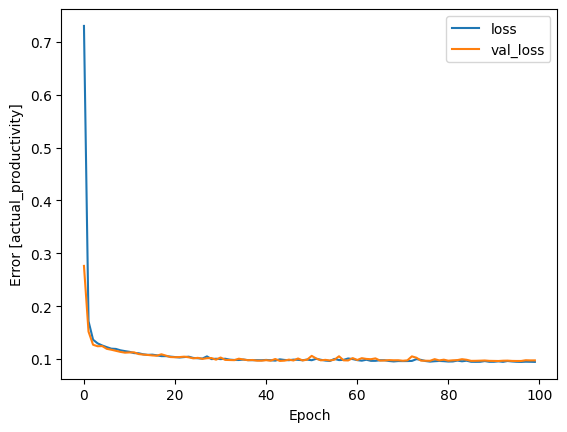

In [696]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error [actual_productivity]')
plt.legend()

In [697]:
test_res['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)

In [698]:
test_res

{'linear_model': 0.02271071821451187, 'dnn_model': 0.09467970579862595}

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


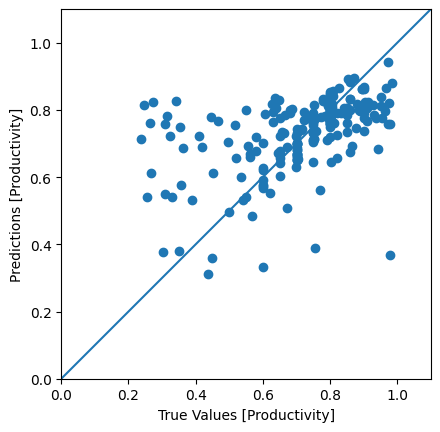

In [699]:
test_pred = dnn_model.predict(X_test).flatten()

plt.axes(aspect='equal')
plt.scatter(y_test, test_pred)
plt.xlabel('True Values [Productivity]')
plt.ylabel('Predictions [Productivity]')
lims = [0, 1.1]
plt.xlim(lims)
plt.ylim(lims)
_=plt.plot(lims, lims)

## Evaluacion de los modelos

In [700]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

In [701]:
#Prediccion del modelo lineal
linear_model_pred = linear_model.predict(X_test).flatten()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step


In [702]:
# Calcular métricas para el modelo lineal
mae_ml = mean_absolute_error(y_test, linear_model_pred)
mse_ml = mean_squared_error(y_test, linear_model_pred)
rmse_ml = np.sqrt(mse_ml)
r2_ml = r2_score(y_test, linear_model_pred)


In [703]:
#Evaluacion del modelo DNN
dnn_model_pred= dnn_model.predict(X_test).flatten()

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


In [704]:
# Calcular métricas para el modelo DNN
mae_dnn = mean_absolute_error(y_test, dnn_model_pred)
mse_dnn = mean_squared_error(y_test, dnn_model_pred)
rmse_dnn = np.sqrt(mse_dnn)
r2_dnn = r2_score(y_test, dnn_model_pred)

In [705]:
# Create a DataFrame to compare the metrics of the models
metrics_comparison = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R^2 Score'],
    'Linear Model': [mae_ml, mse_ml, rmse_ml, r2_ml],
    'DNN Model': [mae_dnn, mse_dnn, rmse_dnn, r2_dnn]
})

# Print the DataFrame
print(metrics_comparison)

                           Metric  Linear Model  DNN Model
0       Mean Absolute Error (MAE)      0.107192   0.094680
1        Mean Squared Error (MSE)      0.022711   0.021802
2  Root Mean Squared Error (RMSE)      0.150701   0.147655
3                       R^2 Score      0.198579   0.230644
